In [33]:
from pathlib import Path
import xarray as xr
import numpy as np
import tiledb
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import sys
import zarr
import numcodecs

In [2]:
sys.version

'3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:18:42) \n[Clang 10.0.1 ]'

In [3]:
SATELLITE_DATA_PATH = Path('~/data/EUMETSAT/reprojected/just_UK/2019/06/03/').expanduser()
ZARR_PATH = Path('~/data/EUMETSAT/zarr/reprojected/just_UK.zarr').expanduser()

In [4]:
if not ZARR_PATH.exists():
    ZARR_PATH.mkdir(parents=True)

In [5]:
netcdf_filenames = SATELLITE_DATA_PATH.glob('*.nc')
netcdf_filenames = list(netcdf_filenames)
netcdf_filenames.sort()
num_nc_files = len(netcdf_filenames)
print(f'{num_nc_files} netcdf files found.')

18 netcdf files found.


In [200]:
%%time

concat_da = []
for filename in netcdf_filenames:
    da = xr.open_dataset(filename)['HRV']
    concat_da.append(da)

concat_da = xr.concat(concat_da, dim='time')

CPU times: user 4.04 s, sys: 1.11 s, total: 5.15 s
Wall time: 5.29 s


In [201]:
dtype = np.uint16
bits_per_pixel = 12
# SEVIRI is 10 bpp

if dtype == np.uint16 or dtype == np.uint8:
    # Normalise
    concat_da -= concat_da.min()
    concat_da /= concat_da.max()
    concat_da *= (2 ** bits_per_pixel) - 1
    concat_da = concat_da.round()

concat_da = concat_da.astype(dtype)

In [202]:
concat_da.min(), concat_da.max()

(<xarray.DataArray 'HRV' ()>
 array(0, dtype=uint16),
 <xarray.DataArray 'HRV' ()>
 array(4095, dtype=uint16))

In [203]:
concat_ds = xr.Dataset({'HRV': concat_da})

In [204]:
%%time
#compressor = numcodecs.Blosc(cname="zstd", clevel=5) #, shuffle=numcodecs.Blosc.BITSHUFFLE)
#compressor = numcodecs.lzma.LZMA()
compressor = numcodecs.Blosc(cname="zstd", clevel=5)

filters = [numcodecs.Delta(dtype=dtype)]
filters = None
chunks = None # (4, 512, 512)

encoding = {'HRV': {
    'compressor': compressor, 
    'filters': filters, 
    #'chunks': chunks
}}
concat_ds.to_zarr(ZARR_PATH, mode='w', encoding=encoding)

CPU times: user 27.7 s, sys: 3.46 s, total: 31.2 s
Wall time: 7.08 s


```
* no compression, float32:  1,160 MB
* no compression, float16:    543 MB
* no compression, uint16:     660 MB

* zstd, clevel=9, shuffle=2: 1m 19s; 594 MB
```

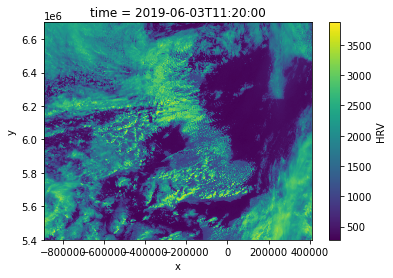

In [169]:
concat_ds['HRV'].isel(time=100).plot()

## Read Zarr

In [207]:
%%time
read_ds = xr.open_zarr(str(ZARR_PATH))

CPU times: user 5.51 ms, sys: 2 ms, total: 7.51 ms
Wall time: 6.79 ms


In [206]:
%%time
read_ds.load()

CPU times: user 1.15 s, sys: 404 ms, total: 1.55 s
Wall time: 826 ms


<xarray.Dataset>
Dimensions:  (time: 216, x: 1301, y: 1300)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-03T03:00:00 ... 2019-06-03T20:55:00
  * x        (x) int64 -889500 -888500 -887500 -886500 ... 408500 409500 410500
  * y        (y) int64 6699500 6698500 6697500 ... 5402500 5401500 5400500
Data variables:
    HRV      (time, y, x) uint16 12 12 4 2 8 12 11 12 12 ... 3 11 8 4 3 4 8 8 3

In [208]:
%%time
ds_rect = read_ds['HRV'][:, 128:256, 128:256]
_ = ds_rect.values

CPU times: user 61.4 ms, sys: 15.6 ms, total: 77 ms
Wall time: 29.6 ms


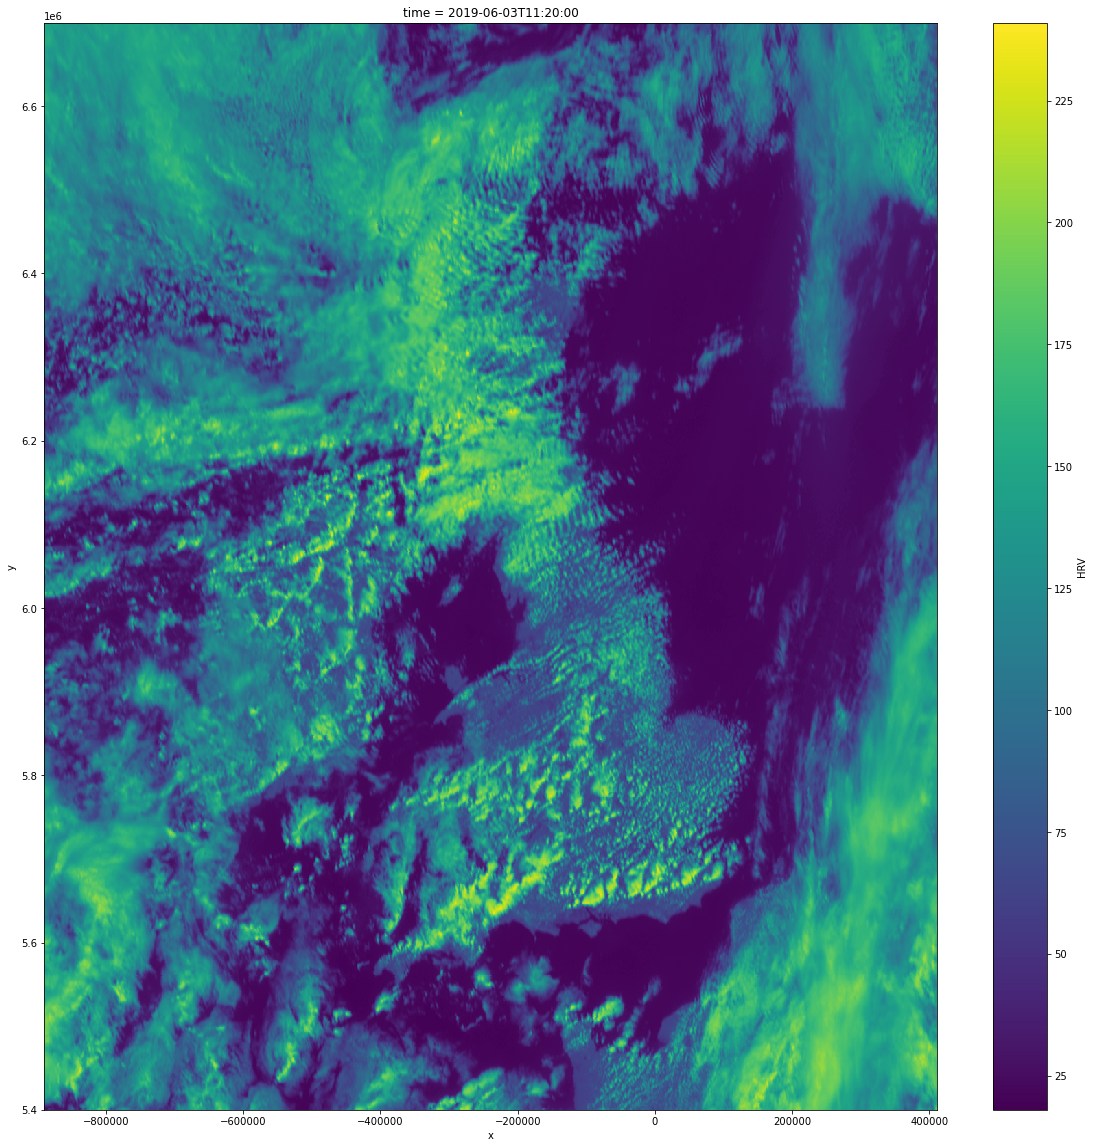

In [194]:
read_ds['HRV'].isel(time=100).plot(figsize=(20, 20));

In [146]:
len(np.unique(read_ds['HRV'].values))

32904